# Atomic Physics
Tables and figures associated with the atomic physics details

In [1]:
import numpy as np
import plasmapy.atomic
from scipy.interpolate import splev
import matplotlib.pyplot as plt
import seaborn
from astropy.table import Table,Column
from astropy.io import ascii
import astropy.units as u
from fiasco import list_elements

from synthesizAR.atomic import EmissionModel,Element
from synthesizAR.instruments import InstrumentSDOAIA

from formatting import get_figsize,qualitative_palette

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [2]:
em = EmissionModel.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_emission_model.json')

## Element Table
List elements, number of ions, total number of lines

In [14]:
by_element = {}
for i in em:
    el = i.atomic_symbol
    if el not in by_element:
        by_element[el] = [i]
    else:
        by_element[el].append(i)
by_element = {k: sorted(v, key=lambda x:x.atomic_number) for k,v in by_element.items()}

In [15]:
col1 = [e[0].atomic_symbol for e in sorted([v for _,v in by_element.items()], key=lambda x: x[0].atomic_number)]

In [16]:
col2 = [len(by_element[x]) for x in col1]

In [17]:
col3 = [sum([i.transitions.wavelength.shape[0] for i in by_element[x] if i.transitions is not None]) for x in col1]

In [18]:
t = Table([col1, col2, col3], names=('Element', 'Number of Ions', 'Number of Transitions'),
          meta={'name': 'CHIANTI Elements'})

In [19]:
caption = r"""Elements included in the calculation of \autoref{eq:intensity}. Ions and transitions are those included in the CHIANTI atomic database.\label{tab:elements}
"""

In [20]:
ascii.write(t, output='tex/element_table.tex', format='aastex',caption=caption,overwrite=True)

## Effective Response Functions
Show the response functions when including the selected elements

In [3]:
aia = InstrumentSDOAIA([0,1]*u.s,observer_coordinate=None)

In [4]:
calc_temp_response = {}
for channel in aia.channels:
    counts = np.zeros(em.temperature.shape+em.density.shape)
    components = {}
    for ion in em:
        wvl,emiss = em.get_emissivity(ion)
        if wvl is None or emiss is None:
            continue
        response = splev(wvl.value, channel['wavelength_response_spline'])
        response = np.where(response < 0., 0., response)
        tmp = np.dot(emiss.value, response)
        tmp *= ion.abundance.value*ion.ioneq.value[:,np.newaxis]/em.density.value/4./np.pi
        counts += tmp
        if ion.element_name in components:
            components[ion.element_name] += tmp
        else:
            components[ion.element_name] = tmp
    calc_temp_response[channel['name']] = counts
    calc_temp_response[f'{channel["name"]}_components'] = components

In [5]:
p = 10**(15)*u.K/(u.cm**3)
const_p_indices = np.array([(i,np.argmin(np.fabs(em.density.value-d.value))) 
                            for i,d in enumerate(p/em.temperature)])

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFa

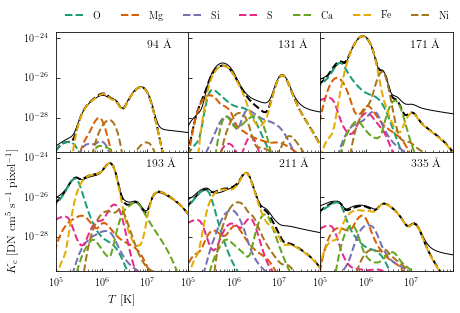

In [6]:
fig,axes = plt.subplots(2,3,figsize=get_figsize(wf=1,),sharex=True,sharey=True)
colors = qualitative_palette(len(calc_temp_response['94_components']))
data_temperature = np.logspace(5,8,100)
for i,(ax,channel) in enumerate(zip(axes.flatten(),aia.channels)):
    real_response = splev(data_temperature, channel['temperature_response_spline'])
    ax.plot(data_temperature, real_response, ls='-',color='k',)
    ax.plot(em.temperature, calc_temp_response[channel['name']][const_p_indices[:,0],const_p_indices[:,1]],
            color='k',ls='--',lw=2)
    elements = sorted(list(calc_temp_response[f'{channel["name"]}_components']), key=lambda x: plasmapy.atomic.atomic_number(x))
    for j,element in enumerate(elements):
        ax.plot(em.temperature,
                calc_temp_response[f'{channel["name"]}_components'][element][const_p_indices[:,0],const_p_indices[:,1]],
                color=colors[j], ls='--', label=plasmapy.atomic.atomic_symbol(element), lw=2)
    if i==0:
        ax.legend(ncol=len(elements),loc="lower left", bbox_to_anchor=(0,1.02),frameon=False)
    ax.text(1e7,3e-25,f'{channel["name"]} $\mathrm{{\AA}}$',fontsize=plt.rcParams['axes.labelsize'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-30,2e-24])
ax.set_xlim([1e5,8e7])
axes[1,0].set_ylabel(r'$K_c$ [DN cm$^5$ s$^{-1}$ pixel$^{-1}$]')
axes[1,0].set_xlabel(r'$T$ [K]')
plt.subplots_adjust(wspace=0.,hspace=0.)
fig.savefig('figures/aia_response.pdf')